### Домашнее задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [ ]:
! pip install shap
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm.auto import tqdm
from xgboost import XGBClassifier, XGBModel
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, classification_report, recall_score, accuracy_score, \
        r2_score

tqdm.pandas()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d yasserh/breast-cancer-dataset

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 1.50MB/s]


In [ ]:
! unzip /content/breast-cancer-dataset.zip

Archive:  /content/breast-cancer-dataset.zip
  inflating: breast-cancer.csv       


*Вспомогательные функции и классы.*

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def get_feature_names_out(self, feature_names_out):
        if feature_names_out:
            return feature_names_out
        else:
            return [self.key]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def get_feature_names_out(self, feature_names_out):
        return self.columns

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key, dtype=np.int8)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
def metric_calculation(y_test: np.ndarray, y_predict: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    print(f'Metrics:')

    # r2 = r2_score(y_test, y_predict)
    # print(f"R2 (коэфф. детерминации): {r2}")

    acc = accuracy_score(y_test, y_predict)
    print(f"Accuracy: {acc}")

    f1 = f1_score(y_test, y_predict)
    print(f"F1: {f1}")

    roc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc}")

    rec = recall_score(y_test, y_predict)
    print(f"Recall: {rec}")

    prc = precision_score(y_test, y_predict)
    print(f"Precision: {prc}")

    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")

    return {"accuracy": acc, "f1 score": f1, "roc-auc score": roc, "recal score": rec, "precision score": prc, "conf_matrix": cm}

In [ ]:
def plot_precision_recall_curve(y_true, y_pred_score, beta=1):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_score)
    fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

    if np.isnan(fscore).any():
        fscore = np.nan_to_num(fscore, nan=0.0)

    # locate the index of the largest f score
    ix = np.argmax(fscore)

    print(f"Best Threshold={thresholds[ix]}",
        f"F-Score={fscore[ix]:.03f}",
        f"Beta={beta}",
        f"Precision={precision[ix]:.03f}",
        f"Recall={recall[ix]:.03f}")

    plt.figure(figsize=(9, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=plt.gca())

    plt.axvline(recall[ix], color="red", alpha=1, ls="--",
                label=f"Recall={recall[ix]:.03f}")

    plt.axhline(precision[ix], color="red", alpha=1, ls="-.",
                label=f"Precision={precision[ix]:.03f}")
    plt.title(f"Precision-recall кривая (Max F-score: {fscore[ix]:.03f} beta={beta})")
    plt.legend()
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return precision, recall, thresholds, fscore, ix

def plot_roc_auc_curve(y_true, y_pred_score):
    score = roc_auc_score(y_true, y_pred_score)
    print(f"ROC-AUC score: {score:.03f}")

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    plt.figure(figsize=(9, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
    plt.title(f"ROC-AUC кривая (Score: {score:.03f})")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return score

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")

    plt.figure(figsize=(9, 6))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(ax=plt.gca(), cmap='cividis')
    plt.title("Матрица ошибок")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return cm

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Описание датасета.

Рак молочной железы является наиболее распространенным видом рака среди женщин в мире. На его долю приходится 25% всех случаев рака, и только в 2015 году от него пострадало более 2,1 миллиона человек. Это начинается, когда клетки молочной железы начинают бесконтрольно расти. Эти клетки обычно образуют опухоли, которые можно увидеть на рентгеновском снимке или почувствовать в виде комков в области груди.

Основные проблемы, связанные с его обнаружением, заключаются в том, как классифицировать опухоли на злокачественные (раковые) или доброкачественные (не раковые). Мы просим вас завершить анализ классификации этих опухолей с использованием машинного обучения (с SVM) и набора данных рака молочной железы Висконсин (диагностический).

*Загрузка и обзор датасета.*

In [ ]:
df = pd.read_csv("/content/breast-cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df = df.replace({'diagnosis':{'M':1, 'B':0}})

In [ ]:
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [ ]:
df.dtypes

id                           int64
diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.14 MB
Memory usage after optimization is: 0.07 MB
Decreased by 51.1%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int32  
 1   diagnosis                569 non-null    int8   
 2   radius_mean              569 non-null    float32
 3   texture_mean             569 non-null    float32
 4   perimeter_mean           569 non-null    float32
 5   area_mean                569 non-null    float32
 6   smoothness_mean          569 non-null    float32
 7   compactness_mean         569 non-null    float32
 8   concavity_mean           569 non-null    float32
 9   concave points_mean      569 non-null    float32
 10  symmetry_mean            569 non-null    float32
 11  fractal_dimension_mean   569 non-null    float32
 12  radius_se                569 non-null    float32
 13  texture_se               569 non-null    float32
 14  perimeter_se             5

In [ ]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289650,91.969032,654.889038,0.096360,0.104341,0.088799,0.048919,...,16.269192,25.677223,107.261215,880.583130,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914124,0.014064,0.052813,0.079720,0.038803,...,4.833241,6.146257,33.602543,569.356995,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,...,7.930000,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,...,13.010000,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,...,14.970000,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,...,18.790001,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,...,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


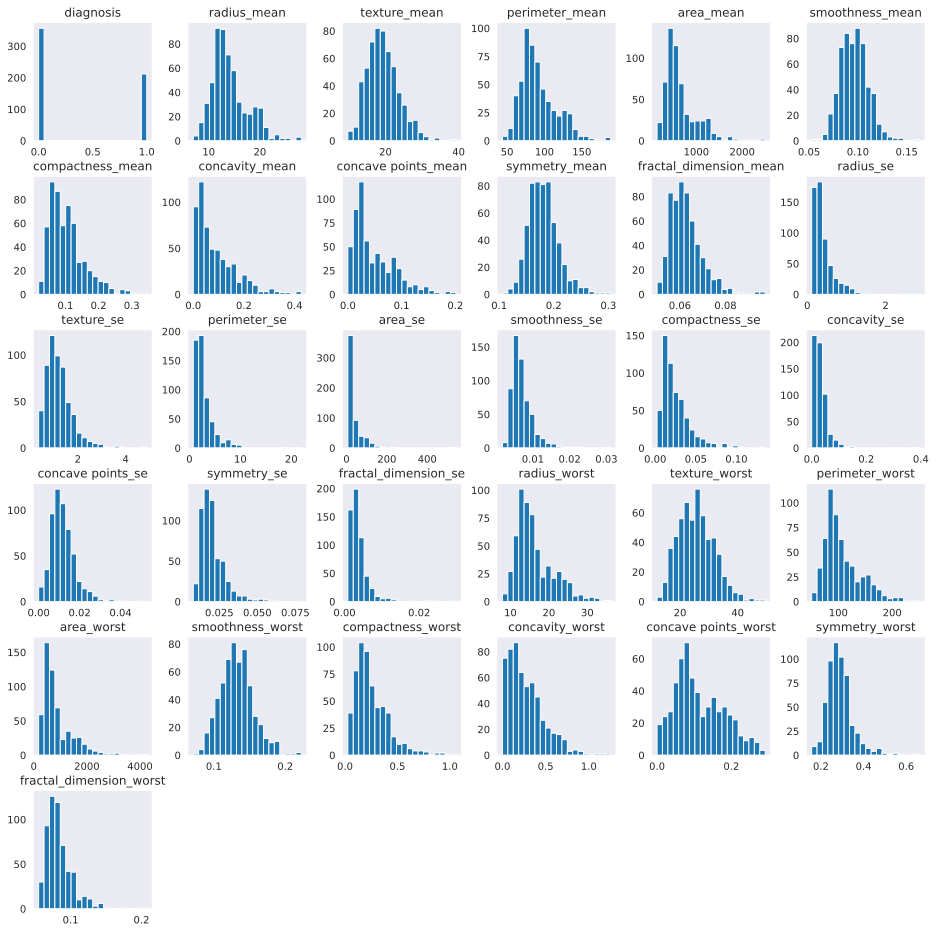

In [ ]:
df.iloc[:, 1:].hist(figsize=(16,16), bins=20, grid=False);

*Проверим корреляцию признаков.*

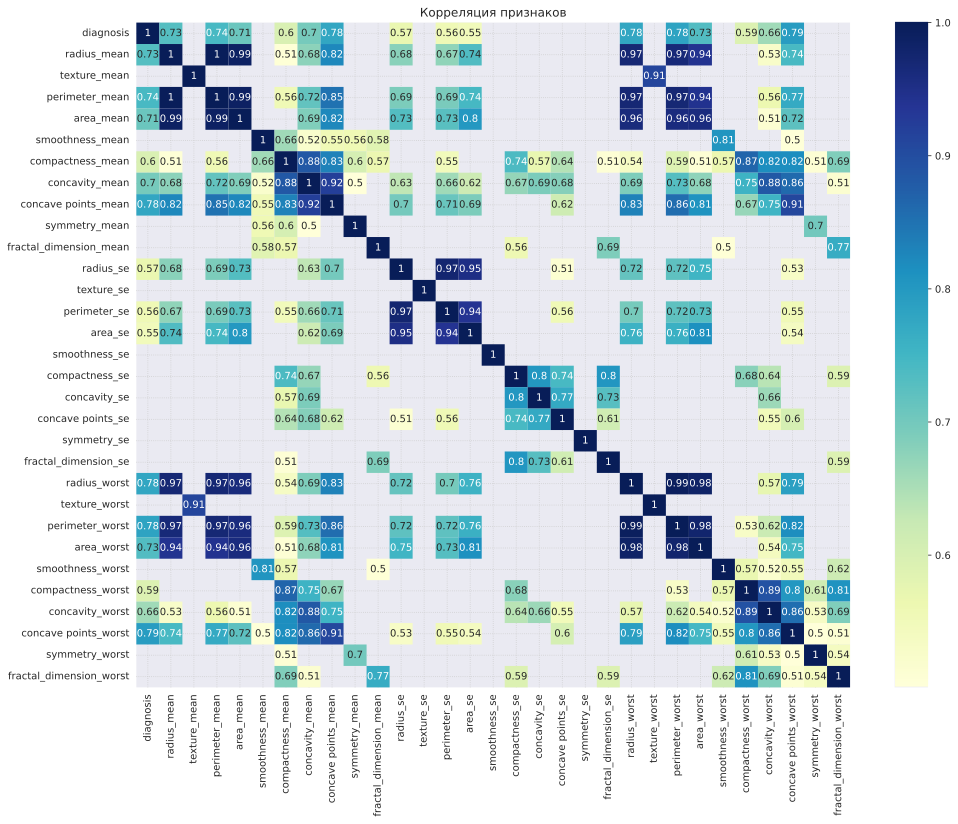

In [ ]:
corr = df.iloc[:, 1:].corr()
filt_corr = corr[np.abs(corr) >= 0.5]

plt.figure(figsize=(16, 12))
sns.heatmap(filt_corr, cmap="YlGnBu", annot=True)
plt.title("Корреляция признаков")
plt.show()

### Разделение датасета на тренировочную и валидационную часть.

In [ ]:
feat_list = list(df)[2:]

In [ ]:
FEATS = feat_list
TARGET = 'diagnosis'

X_train, X_test, y_train, y_test = train_test_split(df[FEATS], df[TARGET], test_size=0.3, stratify=df[TARGET], random_state=42)

In [ ]:
classifier = 'XGBClassifier'

In [ ]:
TRANSFORMERS = []

for col in FEATS:
    TRANSFORMERS.append((col, Pipeline([('selector', FeatureSelector(key=col)), ('scaler', StandardScaler())])))


vc = y_train.value_counts()
scale_pos_weight = int(vc[0] / vc[1])

print(f"Соотношение классов '0' и '1': {scale_pos_weight}")

clf_params = {
    'CatBoostClassifier': {
        'loss_function': 'Logloss',
        'auto_class_weights': 'Balanced',
        'depth': 6,
        'iterations': 300,
        'learning_rate': 0.01,
        'eval_metric': 'AUC',
        'verbose': 200
    },
    'XGBClassifier': {
        'verbosity': 1,
        'max_depth': 5,
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'subsample': 0.5,
        'sampling_method': 'uniform', # 'gradient_based', 'uniform'
        'scale_pos_weight': scale_pos_weight
    },
    'RandomForestClassifier': {
        'n_jobs': -1,
        'n_estimators': 100,
        'criterion': 'gini',
        'max_depth': 5,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': True
    },
    'BaggingClassifier': {
        'n_jobs': -1,
        'n_estimators': 10,
        'verbose': 1
    },
    'DecisionTreeClassifier': {
        'criterion': 'gini',
        'max_depth': 7,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'class_weight': 'balanced',

    },
    'LogisticRegression': {
        'max_iter': 1000,
        'class_weight': 'balanced', # {0:1, 1:10}
        'fit_intercept': True,
        'penalty': 'l2'
    }
}

PIPELINE = Pipeline([('features', FeatureUnion(TRANSFORMERS))])
# опробуем метод сокращения кол-ва фичей
# PIPELINE.steps.append(('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))))

# выбор нужного классификатора
if classifier == 'CatBoostClassifier':
    PIPELINE.steps.append(('clf', CatBoostClassifier(random_state=42, **clf_params['CatBoostClassifier'])))
elif classifier == 'XGBClassifier':
    PIPELINE.steps.append(('clf', XGBClassifier(random_state=42, **clf_params['XGBClassifier'])))
elif classifier == 'RandomForestClassifier':
    PIPELINE.steps.append(('clf', RandomForestClassifier(random_state=42, **clf_params['RandomForestClassifier'])))
elif classifier == 'BaggingClassifier':
    PIPELINE.steps.append(('clf', BalancedBaggingClassifier(random_state=42, **clf_params['BaggingClassifier'])))
elif classifier == 'DecisionTreeClassifier':
    PIPELINE.steps.append(('clf', DecisionTreeClassifier(random_state=42, **clf_params['DecisionTreeClassifier'])))
else:
    PIPELINE.steps.append(('clf', LogisticRegression(random_state=42, **clf_params['LogisticRegression'])))

PIPELINE.verbose = True


# тренировка
PIPELINE.fit(X_train, y_train)


Соотношение классов '0' и '1': 1
[Pipeline] .......... (step 1 of 2) Processing features, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.1s


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('radius_mean',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='radius_mean')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('texture_mean',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='texture_mean')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('perimeter_mean',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='pe...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))],
         verbose=True)

### Метрики

In [ ]:
# получим вероятности принадлежности к классу '1'
y_test_pred_proba = PIPELINE.predict_proba(X_test)[:, 1]

Best Threshold=0.5422412157058716 F-Score=0.989 Beta=1.5 Precision=1.000 Recall=0.984


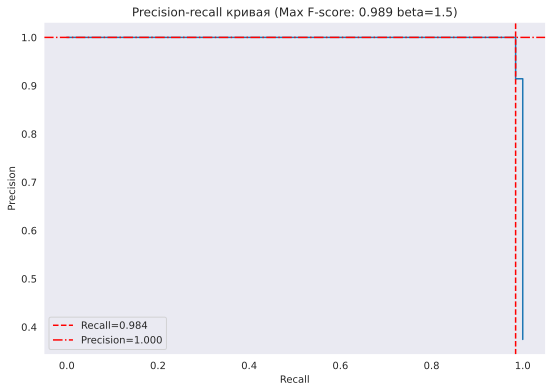

In [ ]:
beta = 1.5
precision, recall, thresholds, fscore, ix = plot_precision_recall_curve(y_test, y_test_pred_proba, beta)

In [ ]:
# y_test_pred = PIPELINE.predict(X_test)
y_test_pred = y_test_pred_proba > thresholds[ix]

In [ ]:
metrics = metric_calculation(y_test, y_test_pred, y_test_pred_proba)

Metrics:
Accuracy: 0.9883040935672515
F1: 0.9841269841269841
ROC-AUC: 0.999123831775701
Recall: 0.96875
Precision: 1.0
Confusion matrix: TN=107 FP=0 FN=2 TP=62


ROC-AUC score: 0.999


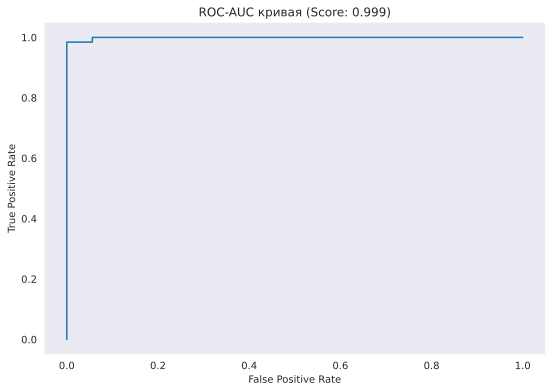

In [ ]:
auc = plot_roc_auc_curve(y_test, y_test_pred_proba)

*Важность признаков*

In [ ]:
feature_names = list(PIPELINE.named_steps['features'].get_feature_names_out())

# if PIPELINE.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
if hasattr(PIPELINE.named_steps['clf'], 'feature_importances_'):
    feature_coeff = PIPELINE.named_steps['clf'].feature_importances_
else:
    feature_coeff = PIPELINE.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({'feature_name': feature_names,
                                   'feature_score': feature_coeff
                                   }).sort_values('feature_score', ascending=False).reset_index(drop=True)
feature_importance

,feature_name,feature_score
0,perimeter_worst__perimeter_worst,0.426733
1,concave points_worst__concave points_worst,0.147811
2,radius_worst__radius_worst,0.093097
3,concave points_mean__concave points_mean,0.042741
4,area_worst__area_worst,0.037655
5,smoothness_mean__smoothness_mean,0.024832
6,concavity_worst__concavity_worst,0.022966
7,texture_mean__texture_mean,0.021926
8,compactness_se__compactness_se,0.018458
9,texture_worst__texture_worst,0.017353


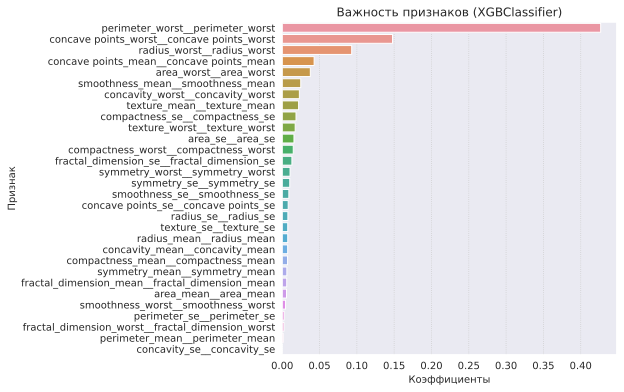

In [ ]:
plt.figure(figsize=(6, 6))
sns.barplot(data=feature_importance, y='feature_name', x='feature_score')
plt.ylabel("Признак")
plt.xlabel("Коэффициенты")
plt.title(f"Важность признаков ({PIPELINE.named_steps['clf'].__class__.__name__})")
plt.show()

## Shap

In [ ]:
if PIPELINE.named_steps['clf'].__class__.__name__ == 'LogisticRegression':
    explainer = shap.LinearExplainer(PIPELINE.named_steps['clf'], X_test)
else:
    explainer = shap.TreeExplainer(PIPELINE.named_steps['clf'], X_test)


sh_values = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


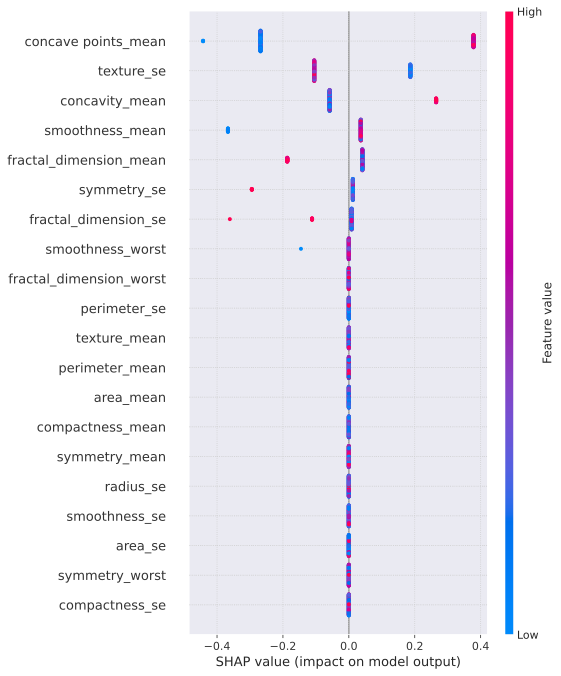

In [ ]:
shap.initjs()
shap.summary_plot(sh_values, X_test)

In [ ]:
shap.initjs()

# id строки данных
pos = 45

shap.force_plot(explainer.expected_value, sh_values[pos,:], X_test.iloc[pos,:])

Среднее значение вогнутости опухоли, среднее значение точек вогнутости опухоли, среднее значение уровней гладкости увеличивают вероятность того, что опухоль злокачественная.


Стандартное отклонение значения фрактальной размерности опухоли и ее среднее значение уменьшает вероятность злокачественности опухоли.

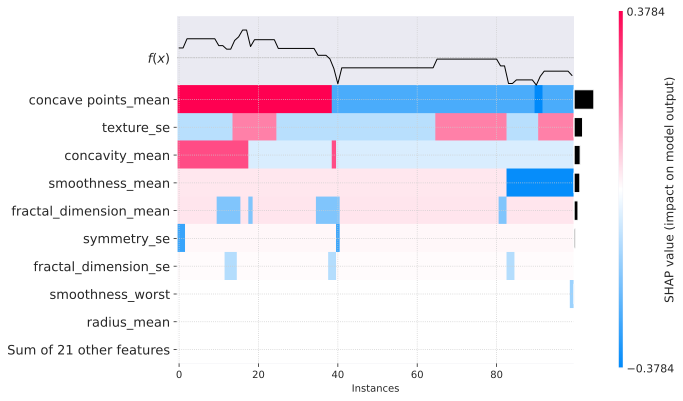

In [ ]:
# shap.initjs()
n = 100
shap.plots.heatmap(explainer(X_test.iloc[:n]))

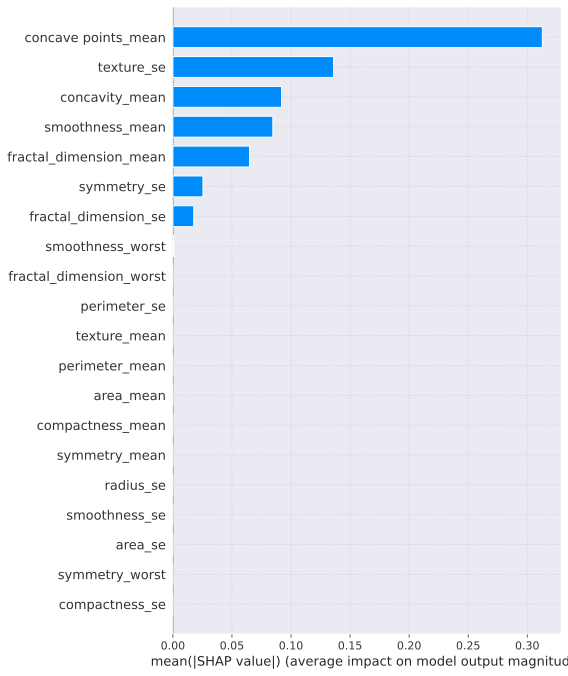

In [ ]:
shap.summary_plot(sh_values, X_train, plot_type="bar")